In [1]:
from myPackage.my_module import *


## Data generation

In [13]:
pio4 = density_matrix(rho2(pi/4,1))
N=200
bins = pio4.bins()['bins']
columns={'Angle':np.zeros(N), 'Visibility': np.zeros(N)}
for i in range(100):
    columns['[' + str(round(bins[i],2)) + ', ' + str(round(bins[i+1],2)) + ']'] = np.zeros(N)

df_test = pd.DataFrame(columns)
for i in range(N):
    vis = np.random.random()
    th = np.random.random()*pi/4
    den = density_matrix(rho2(th, vis))
    df_test['Angle'].iloc[i] = th
    df_test['Visibility'].iloc[i] = vis
    loc_bins = den.bins()['counts']
    for j, bin in enumerate(loc_bins):
        df_test[df.columns[j+2]].iloc[i] = bin
    if(i%5==0):
        print(f'{i}/{N} completed')    

0/200 completed
5/200 completed
10/200 completed
15/200 completed
20/200 completed
25/200 completed
30/200 completed
35/200 completed
40/200 completed
45/200 completed
50/200 completed
55/200 completed
60/200 completed
65/200 completed
70/200 completed
75/200 completed
80/200 completed
85/200 completed
90/200 completed
95/200 completed
100/200 completed
105/200 completed
110/200 completed
115/200 completed
120/200 completed
125/200 completed
130/200 completed
135/200 completed
140/200 completed
145/200 completed
150/200 completed
155/200 completed
160/200 completed
165/200 completed
170/200 completed
175/200 completed
180/200 completed
185/200 completed
190/200 completed
195/200 completed


In [3]:
df_test.to_csv('werner_test.csv')

NameError: name 'df_test' is not defined

In [4]:
df = pd.read_csv('werner_sample.csv', index_col='Unnamed: 0')
df_test = pd.read_csv('werner_test.csv', index_col='Unnamed: 0')
len(df)

10000

In [3]:
import tensorflow as tf
target = tf.constant(df[['Angle', 'Visibility']])
features = tf.constant(df[df.columns[2:]])
target_test = tf.constant(df_test[['Angle', 'Visibility']])
features_test = tf.constant(df_test[df_test.columns[2:]])

## First model

In [4]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input
def model_ang_vis():
    input = Input(shape=(100,))
    hid1 = Dense(95, activation='sigmoid')(input)
    hid2 = Dense(95, activation='sigmoid')(hid1)
    out = Dense(2, activation='sigmoid')(hid2)
    return Model(input, out)
model = model_ang_vis()
model.compile('Adam', loss='mse')

In [5]:
model.fit(features, target, validation_split = 0.2, epochs=50)

Epoch 1/50
250/250 [==============================] - 2s 4ms/step - loss: 0.0654 - val_loss: 0.0505
Epoch 2/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0364 - val_loss: 0.0280
Epoch 3/50
250/250 [==============================] - 1s 3ms/step - loss: 0.0281 - val_loss: 0.0263
Epoch 4/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0270 - val_loss: 0.0253
Epoch 5/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0254 - val_loss: 0.0238
Epoch 6/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0234 - val_loss: 0.0222
Epoch 7/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0200 - val_loss: 0.0192
Epoch 8/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.0112
Epoch 9/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0095 - val_loss: 0.0074
Epoch 10/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0068 - val_loss: 0.0058

In [6]:
model.save('Werner_ml_model.keras')

### First model evaluation

In [7]:
model.evaluate(features_test, target_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.0035


0.003525911830365658

In [8]:
outliers = []
diff = (model.predict(features_test) - target_test).numpy()
res = np.sum(np.abs(diff), axis=1)
res = pd.Series(res)
diff = pd.DataFrame({'Diff_angle': diff[:,0], 'Diff_visibility': diff[:,1]})
selection = np.logical_and(res.values > 0.08, res.values < 0.12)
selected_diff = diff.loc[selection]
high = np.quantile(res.values,0.75)
low = np.quantile(res.values, 0.25)
iqr = high - low
for i, val in enumerate(res.values):
    if val> high + 1.5*iqr:
        outliers.append(i)

outliers

7/7 [==============================] - 0s 4ms/step


[16,
 26,
 76,
 89,
 90,
 92,
 98,
 108,
 112,
 114,
 115,
 120,
 121,
 125,
 129,
 148,
 155,
 162,
 173,
 180,
 183,
 190,
 198]

In [9]:
model.predict(features_test[190:191])

1/1 [==============================] - 0s 33ms/step


array([[0.24322, 0.53345]], dtype=float32)

In [10]:
target_test[190]

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.00049, 0.51044])>

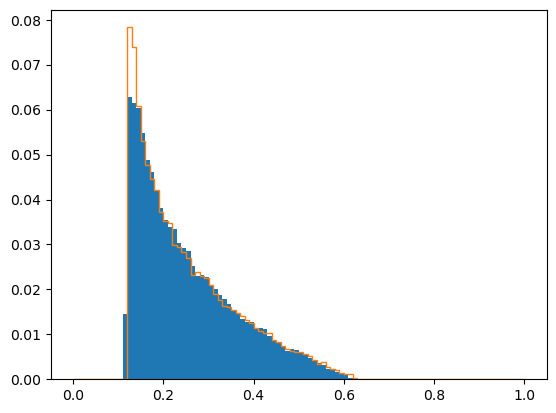

In [11]:
double_plot(density_matrix(rho2(0.21798, 0.52919)),density_matrix(rho2(0.00049, 0.51044)))

In [13]:
matrix_fidelity(density_matrix(rho2(0.21798, 0.52919)),density_matrix(rho2(0.00049, 0.51044)))

0.9832133398952632

(array([25., 28., 19., 26., 34., 21.,  9.,  5.,  4.,  3.,  3.,  0.,  1.,
         2.,  4.,  6.,  2.,  3.,  3.,  2.]),
 array([0.00529, 0.01831, 0.03134, 0.04436, 0.05738, 0.07041, 0.08343,
        0.09645, 0.10948, 0.1225 , 0.13552, 0.14854, 0.16157, 0.17459,
        0.18761, 0.20064, 0.21366, 0.22668, 0.2397 , 0.25273, 0.26575]),
 <BarContainer object of 20 artists>)

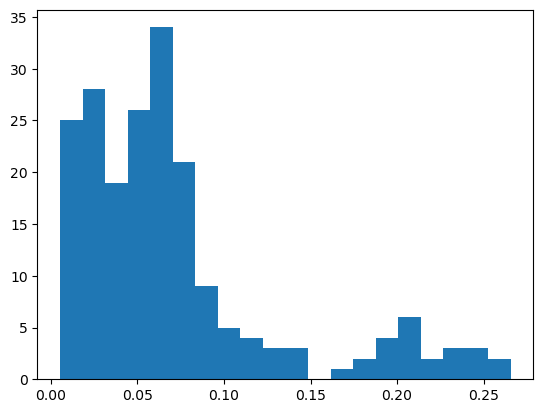

In [14]:
plt.hist(res, bins=20)

array([[<Axes: title={'center': 'Diff_angle'}>,
        <Axes: title={'center': 'Diff_visibility'}>]], dtype=object)

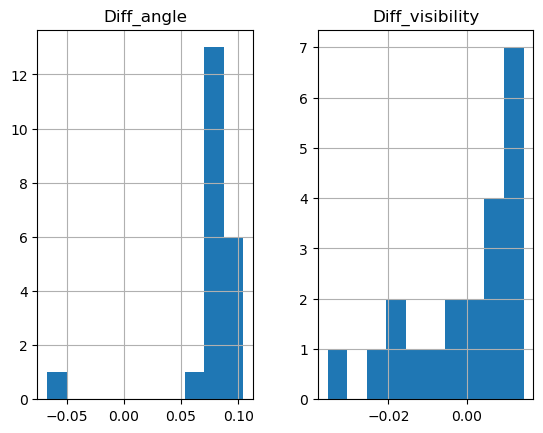

In [15]:
selected_diff.hist()

In [44]:
for x in target[120:124].numpy():
    print(x)

[0.09515 0.66304]
[0.59575 0.02653]
[0.63766 0.68764]
[0.32356 0.96751]


In [17]:
import seaborn as sns

<Axes: xlabel='Diff_visibility', ylabel='Diff_angle'>

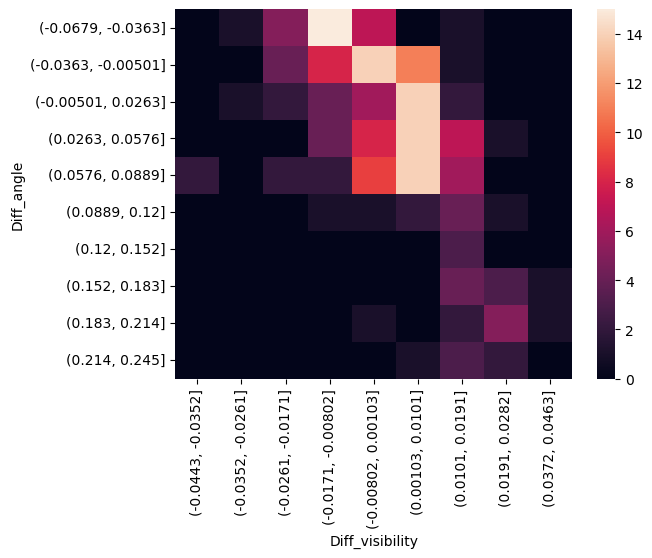

In [18]:
sns.heatmap(pd.crosstab(index=pd.cut(diff['Diff_angle'], 10), columns=pd.cut(diff['Diff_visibility'], 10)))

In [21]:
diff

,Diff_angle,Diff_visibility
0,-0.024319,-0.003179
1,-0.049242,-0.007776
2,0.005318,-0.005081
3,0.083172,-0.015026
4,-0.020306,-0.000055
...,...,...
195,0.001070,-0.007167
196,0.076375,-0.018359
197,0.104321,0.013495
198,0.170604,0.015037


<Axes: xlabel='Diff_visibility', ylabel='Diff_angle'>

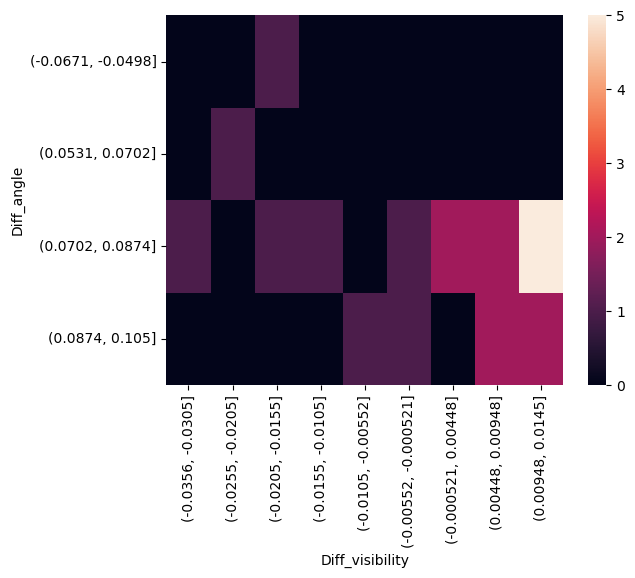

In [20]:
sns.heatmap(pd.crosstab(index=pd.cut(selected_diff['Diff_angle'], 10), columns=pd.cut(selected_diff['Diff_visibility'], 10)))

In [50]:
target_df = df[['Angle', 'Visibility']]
target_df.loc[np.logical_and(res.values > 0.08, res.values < 0.12)]

,Angle,Visibility
0,0.333026,0.045424
4,0.401182,0.933977
9,0.427248,0.961864
13,0.458526,0.500725
19,0.367713,0.008877
...,...,...
9980,0.108705,0.591501
9981,0.313705,0.892598
9983,0.280615,0.895911
9986,0.432219,0.019302


<Axes: xlabel='Visibility', ylabel='Angle'>

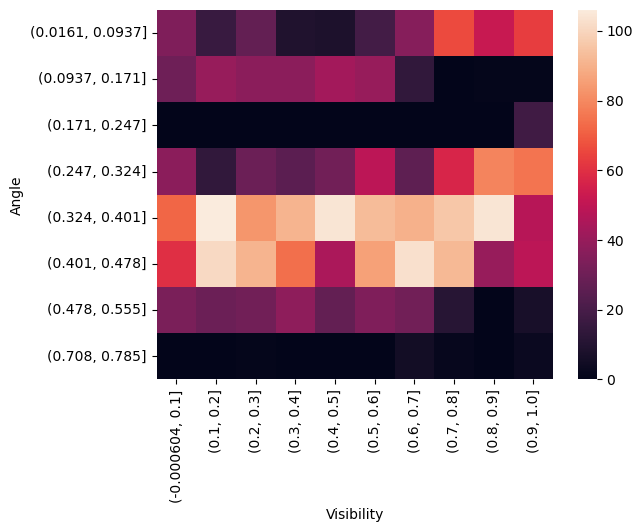

In [51]:
sns.heatmap(pd.crosstab(index=pd.cut(target_df['Angle'].loc[selection], 10), columns=pd.cut(target_df['Visibility'].loc[selection], 10)))

<Axes: xlabel='Visibility', ylabel='Angle'>

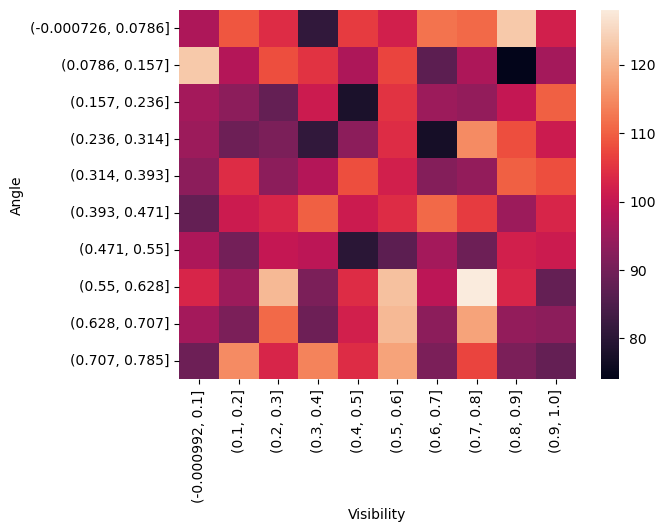

In [52]:
sns.heatmap(pd.crosstab(index=pd.cut(target_df['Angle'], 10), columns=pd.cut(target_df['Visibility'], 10)))

## Second model

In [34]:


def fid_loss(y_true, y_pred):
    y_true_np = np.array([el.numpy() for el in tf.unstack(y_true)])
    y_pred_np = np.array([el.numpy() for el in tf.unstack(y_pred)])
    y_true_ang = y_true_np[:,0]
    y_true_vis = y_true_np[:,1]
    y_pred_ang = y_pred_np[:,0]
    y_pred_vis = y_pred_np[:,1]
    
    coss = np.cos(y_true_ang - y_pred_ang)
    
    anti_fid = tf.constant(1 - (y_true_vis*y_pred_vis*(coss*coss - 0.25) + 0.25))
    loss = tf.reduce_mean(tf.square(anti_fid))
    
    return loss
     

In [48]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, Input
def model_ang_vis():
    input = Input(shape=(100,))
    hid1 = Dense(95, activation='sigmoid')(input)
    hid2 = Dense(95, activation='sigmoid')(hid1)
    out = Dense(2, activation='sigmoid')(hid2)
    return Model(input, out)
model2 = model_ang_vis()
model2.compile('Adam', loss=fid_loss, run_eagerly=True)

In [49]:
model2.fit(features, target, validation_split = 0.2, epochs=50)

Epoch 1/50


ValueError: No gradients provided for any variable: (['dense_3/kernel:0', 'dense_3/bias:0', 'dense_4/kernel:0', 'dense_4/bias:0', 'dense_5/kernel:0', 'dense_5/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'dense_3/kernel:0' shape=(100, 95) dtype=float32, numpy=
array([[-0.09982, -0.11233, -0.12748, ..., -0.11176, -0.04851,  0.13257],
       [-0.0968 , -0.08774,  0.02443, ...,  0.07357,  0.15807, -0.14982],
       [-0.12891,  0.04491,  0.04765, ...,  0.01991,  0.14749, -0.09256],
       ...,
       [ 0.10404,  0.11393, -0.03652, ...,  0.00839, -0.02558, -0.03456],
       [-0.15566,  0.16516, -0.0146 , ..., -0.10637, -0.14308,  0.08126],
       [-0.11474, -0.16043,  0.00467, ...,  0.02057, -0.00454,  0.07423]],
      dtype=float32)>), (None, <tf.Variable 'dense_3/bias:0' shape=(95,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>), (None, <tf.Variable 'dense_4/kernel:0' shape=(95, 95) dtype=float32, numpy=
array([[ 0.09698, -0.11673, -0.00731, ...,  0.15998, -0.16456, -0.16066],
       [ 0.15164,  0.00006,  0.06375, ..., -0.11412,  0.06451,  0.05492],
       [ 0.09524, -0.17147,  0.07114, ...,  0.12812, -0.00881,  0.01224],
       ...,
       [ 0.15297, -0.0469 ,  0.17266, ...,  0.16245, -0.14617,  0.01523],
       [ 0.12696,  0.09164,  0.12838, ..., -0.02284,  0.1674 , -0.14915],
       [-0.07176, -0.02515,  0.06385, ...,  0.0013 ,  0.00577,  0.08281]],
      dtype=float32)>), (None, <tf.Variable 'dense_4/bias:0' shape=(95,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>), (None, <tf.Variable 'dense_5/kernel:0' shape=(95, 2) dtype=float32, numpy=
array([[ 0.18142, -0.20881],
       [ 0.20165, -0.04191],
       [-0.15219, -0.15157],
       [ 0.02678, -0.05628],
       [-0.06205, -0.05009],
       [-0.109  ,  0.23199],
       [ 0.11828, -0.14682],
       [-0.10553, -0.23442],
       [ 0.08867, -0.06179],
       [-0.08271,  0.0949 ],
       [-0.03909, -0.04177],
       [ 0.13525,  0.18806],
       [ 0.1138 , -0.14329],
       [ 0.10745,  0.11549],
       [-0.13807,  0.01831],
       [ 0.00461, -0.06581],
       [-0.15899,  0.02149],
       [ 0.07021, -0.07635],
       [-0.03226,  0.06019],
       [-0.03869,  0.15354],
       [-0.01386, -0.16084],
       [ 0.00591,  0.15195],
       [-0.04011,  0.05729],
       [ 0.0533 , -0.12994],
       [ 0.22762,  0.23516],
       [-0.15892,  0.00615],
       [-0.1154 , -0.02625],
       [ 0.17598,  0.06102],
       [-0.12561, -0.13543],
       [ 0.02   ,  0.11062],
       [-0.17459, -0.09599],
       [-0.19235, -0.05337],
       [ 0.16974, -0.1764 ],
       [ 0.06845, -0.18281],
       [-0.20241, -0.15712],
       [ 0.20925, -0.03146],
       [ 0.2353 , -0.00355],
       [ 0.09378,  0.14491],
       [-0.01982, -0.16312],
       [-0.14218, -0.08758],
       [ 0.05492,  0.04336],
       [ 0.1697 , -0.04898],
       [ 0.24258, -0.00678],
       [-0.12901,  0.02419],
       [ 0.2186 , -0.06707],
       [-0.00231, -0.23032],
       [ 0.23274, -0.21078],
       [ 0.19594, -0.13048],
       [-0.15191, -0.16324],
       [-0.16253, -0.17267],
       [-0.20253, -0.19747],
       [ 0.17639, -0.06932],
       [-0.22445, -0.14476],
       [-0.06582, -0.19027],
       [ 0.04605, -0.01987],
       [-0.09185,  0.03404],
       [-0.10262, -0.02729],
       [-0.1042 , -0.01679],
       [ 0.14207, -0.13956],
       [ 0.11353, -0.1435 ],
       [ 0.13314,  0.21249],
       [ 0.07085,  0.22546],
       [-0.21735, -0.18596],
       [-0.05041, -0.08121],
       [ 0.21427,  0.11143],
       [-0.23522,  0.10384],
       [-0.23403,  0.1139 ],
       [-0.12879, -0.10056],
       [ 0.14647,  0.09778],
       [-0.1953 , -0.13739],
       [-0.22127, -0.05723],
       [-0.19802, -0.03536],
       [-0.02768,  0.20187],
       [-0.00868, -0.19824],
       [ 0.16007,  0.11602],
       [-0.16095, -0.11365],
       [-0.12508,  0.0778 ],
       [-0.0015 , -0.18279],
       [ 0.07433, -0.24347],
       [-0.19985, -0.07198],
       [-0.17439,  0.10238],
       [ 0.09547,  0.20089],
       [-0.10346,  0.17279],
       [-0.01041,  0.0829 ],
       [ 0.00532, -0.2197 ],
       [ 0.03297, -0.1682 ],
       [-0.03504,  0.08172],
       [-0.14448,  0.20434],
       [ 0.04753,  0.1251 ],
       [ 0.08078,  0.19602],
       [-0.2267 ,  0.21748],
       [ 0.16129,  0.1623 ],
       [ 0.10693,  0.02794],
       [ 0.16615,  0.08008],
       [-0.14546,  0.1402 ]], dtype=float32)>), (None, <tf.Variable 'dense_5/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>)).